![Los Angeles skyline](la_skyline.jpg)

Los Angeles, California 😎. The City of Angels. Tinseltown. The Entertainment Capital of the World! 

Known for its warm weather, palm trees, sprawling coastline, and Hollywood, along with producing some of the most iconic films and songs. However, as with any highly populated city, it isn't always glamorous and there can be a large volume of crime. That's where you can help!

You have been asked to support the Los Angeles Police Department (LAPD) by analyzing crime data to identify patterns in criminal behavior. They plan to use your insights to allocate resources effectively to tackle various crimes in different areas.

## The Data

They have provided you with a single dataset to use. A summary and preview are provided below.

It is a modified version of the original data, which is publicly available from Los Angeles Open Data.

# crimes.csv

| Column     | Description              |
|------------|--------------------------|
| `'DR_NO'` | Division of Records Number: Official file number made up of a 2-digit year, area ID, and 5 digits. |
| `'Date Rptd'` | Date reported - MM/DD/YYYY. |
| `'DATE OCC'` | Date of occurrence - MM/DD/YYYY. |
| `'TIME OCC'` | In 24-hour military time. |
| `'AREA NAME'` | The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example, the 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles. |
| `'Crm Cd Desc'` | Indicates the crime committed. |
| `'Vict Age'` | Victim's age in years. |
| `'Vict Sex'` | Victim's sex: `F`: Female, `M`: Male, `X`: Unknown. |
| `'Vict Descent'` | Victim's descent:<ul><li>`A` - Other Asian</li><li>`B` - Black</li><li>`C` - Chinese</li><li>`D` - Cambodian</li><li>`F` - Filipino</li><li>`G` - Guamanian</li><li>`H` - Hispanic/Latin/Mexican</li><li>`I` - American Indian/Alaskan Native</li><li>`J` - Japanese</li><li>`K` - Korean</li><li>`L` - Laotian</li><li>`O` - Other</li><li>`P` - Pacific Islander</li><li>`S` - Samoan</li><li>`U` - Hawaiian</li><li>`V` - Vietnamese</li><li>`W` - White</li><li>`X` - Unknown</li><li>`Z` - Asian Indian</li> |
| `'Weapon Desc'` | Description of the weapon used (if applicable). |
| `'Status Desc'` | Crime status. |
| `'LOCATION'` | Street address of the crime. |

In [1]:
# Re-run this cell
# Import required libraries
import pandas
import numpy
import matplotlib.pyplot as pyplot
import seaborn

pd = pandas
crimes_df = pandas.read_csv("crimes.csv", parse_dates=["Date Rptd", "DATE OCC"], dtype={"TIME OCC": str})
crimes_df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Weapon Desc,Status Desc,LOCATION
0,221412410,2022-06-15,2020-11-12,1700,Pacific,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0,NaN,NaN,NaN,Invest Cont,13600 MARINA POINT DR
1,220314085,2022-07-22,2020-05-12,1110,Southwest,THEFT OF IDENTITY,27,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
2,222013040,2022-08-06,2020-06-04,1620,Olympic,THEFT OF IDENTITY,60,M,H,NaN,Invest Cont,3300 SAN MARINO ST
3,220614831,2022-08-18,2020-08-17,1200,Hollywood,THEFT OF IDENTITY,28,M,H,NaN,Invest Cont,1900 TRANSIENT
4,231207725,2023-02-27,2020-01-27,0635,77th Street,THEFT OF IDENTITY,37,M,H,NaN,Invest Cont,6200 4TH AV


In [2]:
crimes_df.corr()

,DR_NO,Vict Age
DR_NO,1.00000,-0.01512
Vict Age,-0.01512,1.00000


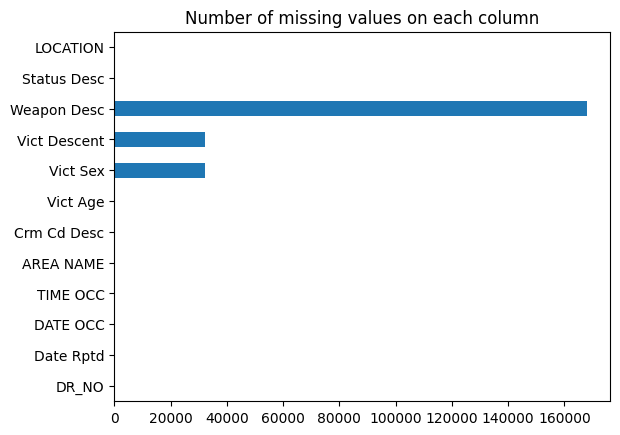

In [3]:
checkna_df = crimes_df.isna().sum()
checkna_df.plot(kind='barh', title='Number of missing values on each column')
pyplot.show()

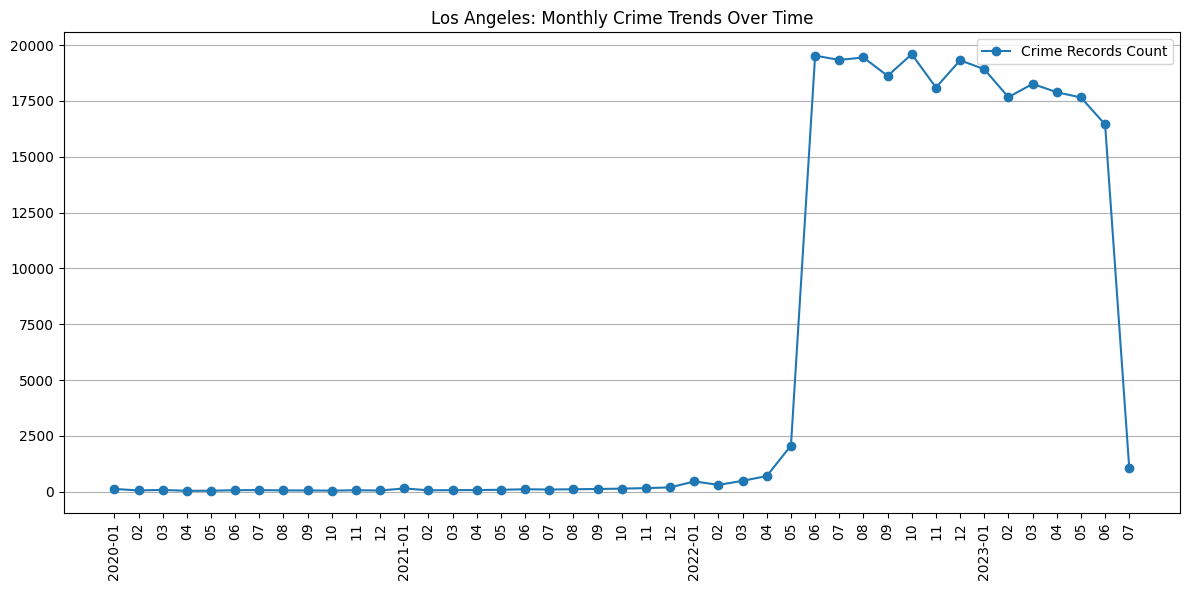

In [4]:
occurence_per_year = crimes_df[['DATE OCC', 'DR_NO']]
occurence_per_year['year'] = occurence_per_year['DATE OCC'].dt.year
occurence_per_year['month'] = occurence_per_year['DATE OCC'].dt.strftime('%Y-%m')

occurence_per_year = (
    occurence_per_year
    .groupby(by='month')['DR_NO']
    .count()
    .to_frame()
    .reset_index()
)
occurence_per_year.rename({'DR_NO':'Crime Records Count'}, axis='columns', inplace=True)
occurence_per_year['pyplot_label'] = occurence_per_year['month'].apply(lambda value: value if value.endswith('-01') else value.split('-')[-1])

occurence_per_year.plot(
    kind='line', 
    marker='o', 
    title='Los Angeles: Monthly Crime Trends Over Time', 
    figsize=(12,6), 
    rot=90
)
pyplot.xticks(
    ticks=[location for location in range(occurence_per_year['pyplot_label'].size)],
    labels=occurence_per_year['pyplot_label'].to_numpy()
)


pyplot.grid(axis='y')
pyplot.tight_layout()
pyplot.show()

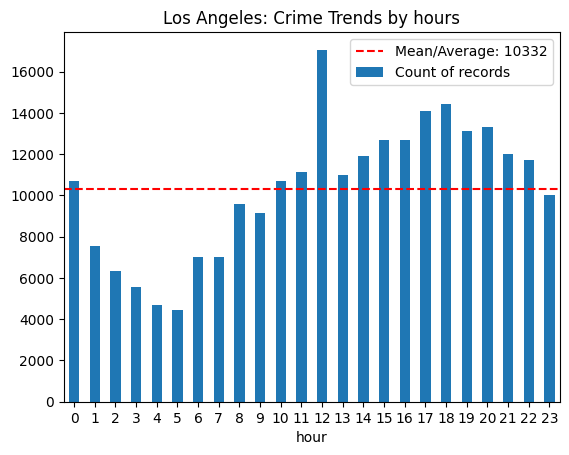

In [5]:
occurence_per_hour = crimes_df[['TIME OCC', 'DR_NO']].copy()
occurence_per_hour['hour'] = occurence_per_hour['TIME OCC'].astype(int) // 100
occurence_per_hour.rename(columns={'DR_NO':'Count of records'}, inplace=True)
occurence_per_hour = (occurence_per_hour
        .groupby(by='hour')['Count of records']
        .count()
)

occurence_per_hour.plot(kind='bar', title='Los Angeles: Crime Trends by hours', rot=0)
pyplot.axhline(occurence_per_hour.mean(), color='red', linestyle='--', label=f'Mean/Average: {int(occurence_per_hour.mean())}')
pyplot.legend()
pyplot.show()

# For project submission
peak_crime_hour = occurence_per_hour.idxmax()

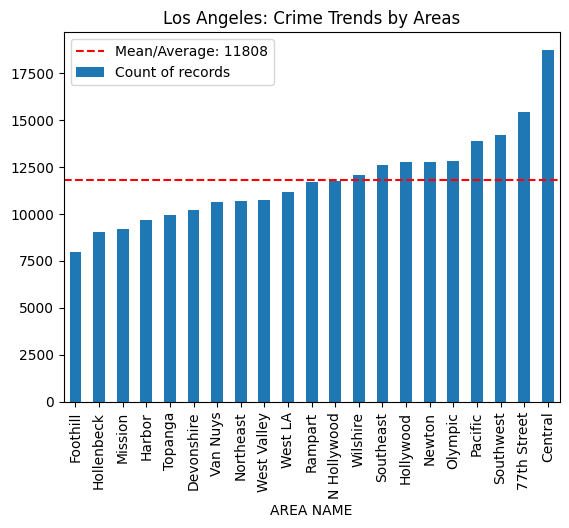

In [6]:

occurence_per_area = crimes_df[['AREA NAME', 'DR_NO']].copy()
occurence_per_area.rename(columns={'DR_NO':'Count of records'}, inplace=True)
occurence_per_area = (occurence_per_area
        .groupby(by='AREA NAME')['Count of records']
        .count()
        .sort_values(ascending=True)
)

occurence_per_area.plot(kind='bar', title='Los Angeles: Crime Trends by Areas')
pyplot.axhline(occurence_per_area.mean(), color='red', linestyle='--', label=f'Mean/Average: {int(occurence_per_area.mean())}')
pyplot.legend()
pyplot.show()

In [7]:
import folium

# Latitudes and longitudes mapping. Data is manually retrieved from Police Station of each area (Source: Google Maps)
la_coordinate = [34.05650644633771, -118.24410970661683]
area_coordinate_mapping = {
    'Foothill': [34.26293906783605, -118.38493831469319], # https://maps.app.goo.gl/jJ8wBYopcYQKZ6DZA
    'Hollenbeck': [34.04502450895756, -118.21323780336581], # https://maps.app.goo.gl/cvetcqDnrDZfSpe7A
    'Mission': [34.27284424328829, -118.46824979397024], # https://maps.app.goo.gl/M1nDHwtKdXvy17Qb7
    'Harbor': [33.75751671704253, -118.28935620412034], # https://maps.app.goo.gl/r9NTAGsTVJzLCihaA
    'Topanga': [34.221423824966735, -118.5991363948628], # https://maps.app.goo.gl/r69N31q8d27umGDg9
    'Devonshire': [34.25678075225115, -118.53102702757637], # https://maps.app.goo.gl/LXf7LCuXiuUuVCjo6
    'Van Nuys': [34.18381054707807, -118.4446891415331], # https://maps.app.goo.gl/9sZqsai1ewxJ6fR29
    'Northeast': [34.11920900889974, -118.24932829774586], # https://maps.app.goo.gl/NcPrzE8zkynPvpwA9
    'West Valley': [34.193645806353345, -118.5476867051721], # https://maps.app.goo.gl/Y6D9tFfPrU7EjWwC9
    'West LA': [34.043811186043136, -118.45068694098744], # https://maps.app.goo.gl/Bo6ZT87yiKvNy7E66
    'Rampart': [34.05669178050328, -118.26708983000873], # https://maps.app.goo.gl/ujVUidad8nQR37Hr6
    'N Hollywood': [34.171684613191246, -118.38593011312389], # https://maps.app.goo.gl/k5pSuLCPGy24irgZA
    'Wilshire': [34.04666015392482, -118.34250949790595], # https://maps.app.goo.gl/siQiooCtzoL5nuuM9
    'Southeast': [33.93853265270789, -118.27531829871263], # https://maps.app.goo.gl/2KR89RvZ1kZ1zXPq6
    'Hollywood': [34.095830177970086, -118.3308214706207], # https://maps.app.goo.gl/EiFj4k7Wbmi4PbRK8
    'Newton': [34.01237728827535, -118.25626505774848 ], # https://maps.app.goo.gl/J3fZ4W4kZY8M2Vxx8
    'Olympic': [34.05029681456887, -118.29116272839525], # https://maps.app.goo.gl/wV2gPwtnGmBM2RcYA
    'Pacific': [33.99166510520878, -118.42007131732467], # https://maps.app.goo.gl/ZQVFEP8WH2XoxdVX8
    'Southwest': [34.0106121409609, -118.30503424438206], # https://maps.app.goo.gl/PjAjwiZU6qom9Ftu9
    '77th Street': [33.970301453876935, -118.27750348770937], # https://maps.app.goo.gl/QeZLufQ5qrmTJELPA
    'Central': [34.04405146681716, -118.24748005592487], # https://maps.app.goo.gl/JWMUiZEGHBNTZABs7
}

la_map = folium.Map(location=la_coordinate, zoom_start=10)

for area in occurence_per_area.index:
    area_occurences = occurence_per_area[area]
    area_long = area_coordinate_mapping[area][0]
    area_lat = area_coordinate_mapping[area][1]
    # Assume a scaling factor
    circle_radius = occurence_per_area[area] * 0.001
    
    folium.CircleMarker(
                        location=[area_long, area_lat], 
                        radius=circle_radius, 
                        popup=f"{area}: {area_occurences}", 
                        color='red' if area_occurences >= occurence_per_area.mean() else 'orange',
                        fill=True, 
                        fill_color='red' if area_occurences >= occurence_per_area.mean() else 'orange'
    ).add_to(la_map)

# Display the map
print('LEGEND:')
print('Orange cirle: Lower than Average')
print('Red cirle: Higher than Average')
la_map

LEGEND:
Orange cirle: Lower than Average
Red cirle: Higher than Average


- It is evident that there is a higher concentration of criminal activities in regions closer to the city center. This trend diminishes progressively as one moves towards the outskirts. 
- The central areas, notably 'Central', with 18,732 reported incidents, exhibit the highest density of crime, contrasting sharply with areas on the periphery, such as 'Foothill', which reported significantly fewer incidents, numbering 7,960.

In [123]:
crimes_df['Vict Sex'].unique()
crimes_df.groupby('Vict Sex').count()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Descent,Weapon Desc,Status Desc,LOCATION
Vict Sex,,,,,,,,,,,
-,1,1,1,1,1,1,1,1,0,1,1
F,90804,90804,90804,90804,90804,90804,90804,90802,35347,90804,90804
H,30,30,30,30,30,30,30,30,5,30,30
M,101028,101028,101028,101028,101028,101028,101028,101027,39738,101028,101028
X,23877,23877,23877,23877,23877,23877,23877,23877,4912,23877,23877


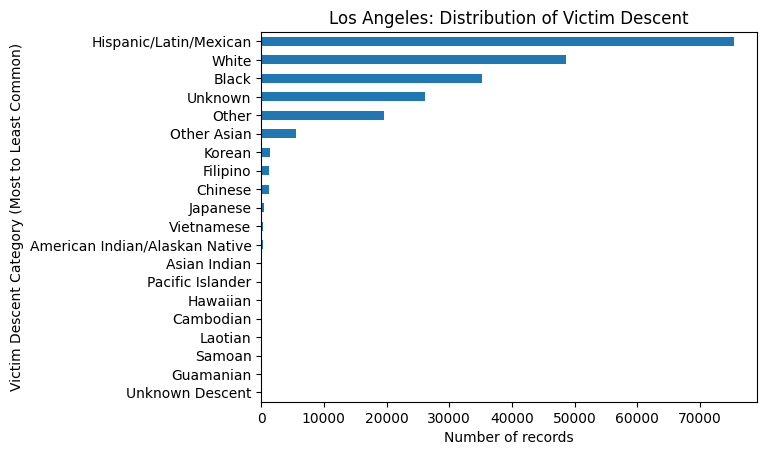

In [124]:
descent_codes = {
    "A": "Other Asian",
    "B": "Black",
    "C": "Chinese",
    "D": "Cambodian",
    "F": "Filipino",
    "G": "Guamanian",
    "H": "Hispanic/Latin/Mexican",
    "I": "American Indian/Alaskan Native",
    "J": "Japanese",
    "K": "Korean",
    "L": "Laotian",
    "O": "Other",
    "P": "Pacific Islander",
    "S": "Samoan",
    "U": "Hawaiian",
    "V": "Vietnamese",
    "W": "White",
    "X": "Unknown",
    "Z": "Asian Indian"
}

victim_descent_dist_df = (crimes_df
    .groupby(by='Vict Descent')['DR_NO']
    .count()
    .rename(index=lambda code: descent_codes.get(code, 'Unknown Descent'))
    .sort_values(ascending=True)
)

victim_descent_dist_df.plot(kind='barh', title='Los Angeles: Distribution of Victim Descent')

victim_descent_dist_xlabel = pyplot.xlabel('Number of records')
pyplot.ylabel('Victim Descent Category (Most to Least Common)')
# pyplot.xticks(rotation=45)


pyplot.show()

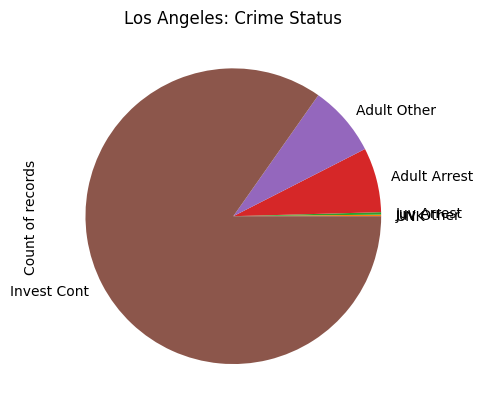

In [125]:
crimes_df['Status Desc'].unique()

occurence_per_status = crimes_df[['Status Desc', 'DR_NO']].copy()
occurence_per_status.rename(columns={'DR_NO':'Count of records'}, inplace=True)
occurence_per_status = (occurence_per_status
        .groupby(by='Status Desc')['Count of records']
        .count()
        .sort_values(ascending=True)
)

occurence_per_status.plot(kind='pie', title='Los Angeles: Crime Status')
pyplot.xlabel('')
pyplot.show()

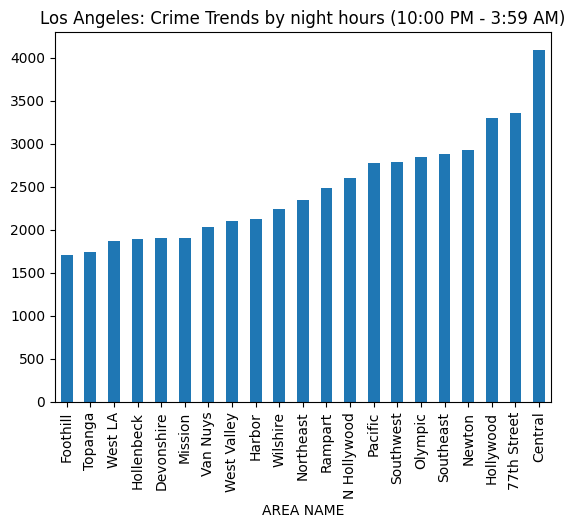

In [126]:
occurence_per_area_hour = crimes_df[['TIME OCC', 'AREA NAME', 'DR_NO']].copy()
occurence_per_area_hour['hour'] = occurence_per_area_hour['TIME OCC'].astype(int) // 100
occurence_per_area_hour.rename(columns={'DR_NO':'Count of records'}, inplace=True)


occurence_per_area_nighthour = occurence_per_area_hour[occurence_per_area_hour['hour'].isin([0,1,2,3,22,23])]
occurence_per_area_nighthour = (occurence_per_area_nighthour
        .groupby(by=['AREA NAME'])['Count of records']
        .count()
        .sort_values(ascending=True)
)

occurence_per_area_nighthour.plot(kind='bar', title='Los Angeles: Crime Trends by night hours (10:00 PM - 3:59 AM)')

pyplot.show()

# For project submission
peak_night_crime_location = occurence_per_area_nighthour.idxmax()

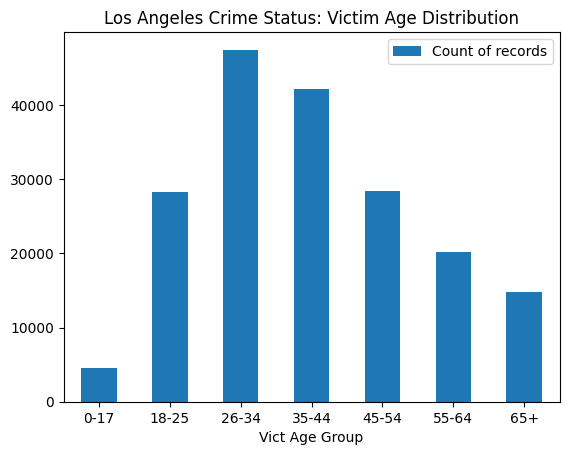

In [127]:
occurence_per_victage = crimes_df[['Vict Age', 'DR_NO']].copy()
occurence_per_victage.rename(columns={'DR_NO':'Count of records'}, inplace=True)

age_bins = [0, 17, 25, 34, 44, 54, 64, np.inf]
age_labels = ["0-17", "18-25", "26-34", "35-44", "45-54", "55-64", "65+"]

occurence_per_victage['Vict Age Group'] = pandas.cut(x=occurence_per_victage['Vict Age'], bins=age_bins, labels=age_bin_labels)

# For project submission
victim_ages = occurence_per_victage['Vict Age Group'].value_counts()

occurence_per_victage = (occurence_per_victage[['Vict Age Group', 'Count of records']]
        .groupby(by='Vict Age Group')
        .count()
)

occurence_per_victage.plot(kind='bar', title='Los Angeles Crime Status: Victim Age Distribution', rot=0)

pyplot.show()